In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Pepper",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


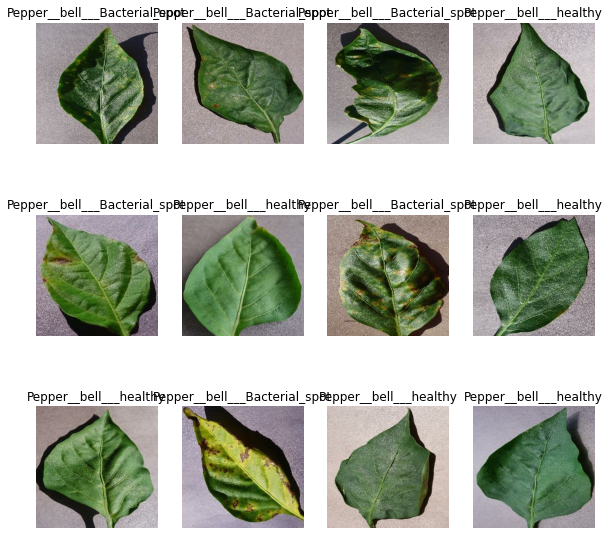

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

62

In [10]:
len(val_ds)

7

In [11]:
len(test_ds)

9

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
62/62 [==============================] - 150s 2s/step - loss: 0.5795 - accuracy: 0.6597 - val_loss: 0.6772 - val_accuracy: 0.8080
Epoch 2/50
62/62 [==============================] - 139s 2s/step - loss: 0.2210 - accuracy: 0.9348 - val_loss: 0.5578 - val_accuracy: 0.7500
Epoch 3/50
62/62 [==============================] - 131s 2s/step - loss: 0.1700 - accuracy: 0.9592 - val_loss: 0.3065 - val_accuracy: 0.9286
Epoch 4/50
62/62 [==============================] - 139s 2s/step - loss: 0.0884 - accuracy: 0.9766 - val_loss: 0.1401 - val_accuracy: 0.9911
Epoch 5/50
62/62 [==============================] - 150s 2s/step - loss: 0.0534 - accuracy: 0.9873 - val_loss: 0.0514 - val_accuracy: 0.9911
Epoch 6/50
62/62 [==============================] - 175s 3s/step - loss: 0.0449 - accuracy: 0.9893 - val_loss: 0.0684 - val_accuracy: 0.9866
Epoch 7/50
62/62 [==============================] - 178s 3s/step - loss: 0.0419 - accuracy: 0.9878 - val_loss: 0.0614 - val_accuracy: 0.9866
Epoch 8/50
62

In [20]:
model.save('pepper.h5')

In [21]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 23s 670ms/step - loss: 0.0249 - accuracy: 0.9861


In [22]:
scores

[0.024868449196219444, 0.9861111044883728]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [25]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

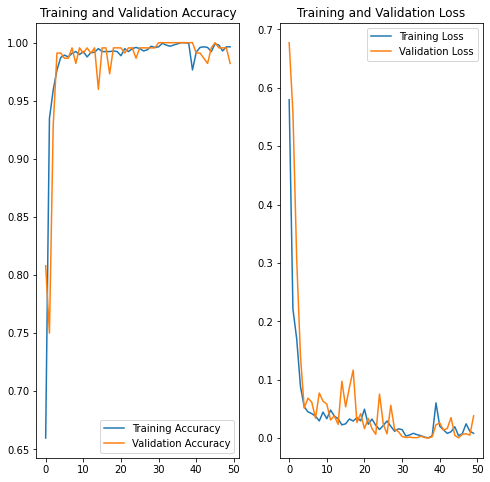

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 3s 3s/step
predicted label: Pepper__bell___Bacterial_spot


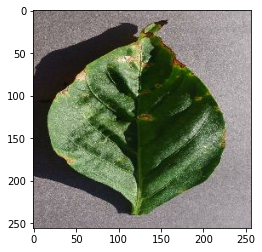

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [60]:
image_path_jpg = r"C:\Users\ROSHAAN\Downloads\download.jpg"
img = tf.io.read_file(image_path_jpg)
img.get_shape().as_list()  # []
img = tf.image.decode_jpeg(img)
img.get_shape().as_list()  # [300, 400, 3]
img_resized = tf.image.resize(img, [256, 256])
img_resized.get_shape().as_list()  # [100, 100, 3]

[256, 256, 3]

In [61]:
predict(model,img_resized)

1/1 [==============================] - 0s 160ms/step


('Pepper__bell___Bacterial_spot', 100.0)